# Pyspark TensorFlow Inference

## Text classification
Based on: https://www.tensorflow.org/tutorials/keras/text_classification

In [1]:
import os
import re
import shutil
import string

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, losses

2024-09-19 18:18:41.812276: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 18:18:41.812334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 18:18:41.813957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 18:18:41.823056: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-19 18:18:42.708569: W tensorflow/comp

In [2]:
print(tf.__version__)

2.15.0


In [3]:
#os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/lib/cuda" # set to path containing /cuda/nvvm/libdevice/

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(
    "aclImdb_v1", url, untar=True, cache_dir=".", cache_subdir=""
)

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

84125825/84125825 [==============================] - 0s 0us/step


In [5]:
os.listdir(dataset_dir)

['README', 'train', 'test', 'imdb.vocab', 'imdbEr.txt']

In [6]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['urls_neg.txt',
 'labeledBow.feat',
 'unsup',
 'urls_unsup.txt',
 'pos',
 'urls_pos.txt',
 'unsupBow.feat',
 'neg']

In [7]:
sample_file = os.path.join(train_dir, "pos/1181_9.txt")
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [8]:
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [9]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2024-09-19 18:19:06.727419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30573 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB-H, pci bus id: 0000:34:00.0, compute capability: 7.0
2024-09-19 18:19:06.729015: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31135 MB memory:  -> device: 1, name: Tesla V100-SXM3-32GB-H, pci bus id: 0000:36:00.0, compute capability: 7.0
2024-09-19 18:19:06.730356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 31135 MB memory:  -> device: 2, name: Tesla V100-SXM3-32GB-H, pci bus id: 0000:39:00.0, compute capability: 7.0
2024-09-19 18:19:06.731694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 31135 MB memory:  -> device: 3, name: Tesla V100-SXM3-32GB-H, pc

In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [11]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [12]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [14]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [16]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [18]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [19]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [20]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
embedding_dim = 16

In [23]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [24]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [25]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


2024-09-19 18:19:14.927995: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9cd6878f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-19 18:19:14.928026: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
2024-09-19 18:19:14.928035: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
2024-09-19 18:19:14.928043: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
2024-09-19 18:19:14.928052: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (3): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
2024-09-19 18:19:14.928061: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (4): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
2024-09-19 18:19:14.928070: I external/loca

625/625 [==============================] - 55s 84ms/step - loss: 0.6645 - binary_accuracy: 0.6932 - val_loss: 0.6151 - val_binary_accuracy: 0.7720
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5482 - binary_accuracy: 0.8025 - val_loss: 0.4975 - val_binary_accuracy: 0.8232
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4442 - binary_accuracy: 0.8456 - val_loss: 0.4194 - val_binary_accuracy: 0.8470
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3779 - binary_accuracy: 0.8663 - val_loss: 0.3733 - val_binary_accuracy: 0.8612
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3351 - binary_accuracy: 0.8793 - val_loss: 0.3448 - val_binary_accuracy: 0.8676
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3052 - binary_accuracy: 0.8896 - val_loss: 0.3258 - val_binary_accuracy: 0.8706
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss:

In [26]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3102 - binary_accuracy: 0.8734
Loss:  0.3102284073829651
Accuracy:  0.8734400272369385


In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

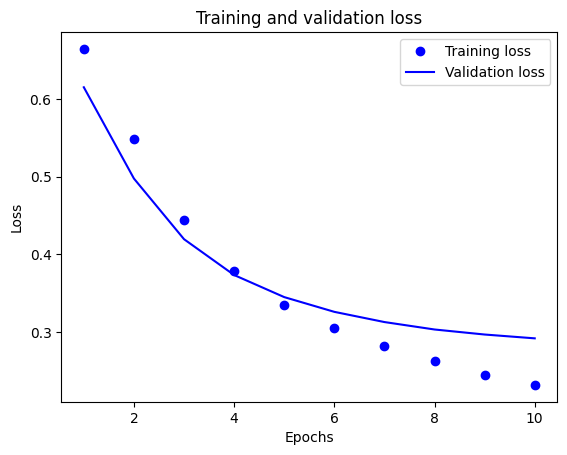

In [28]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

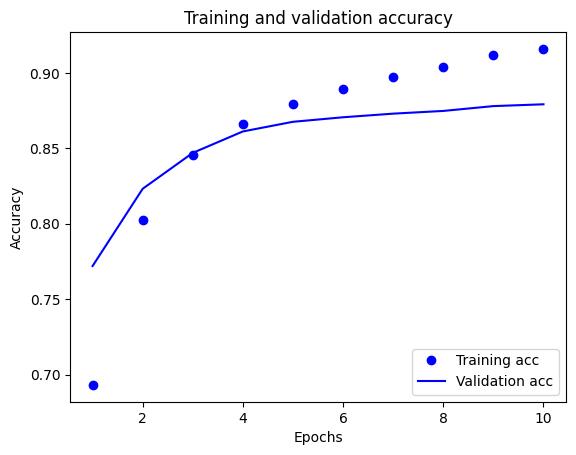

In [29]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [30]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 3s 3ms/step - loss: 0.3102 - accuracy: 0.8734
0.8734400272369385


In [31]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 307ms/step


array([[0.60800725],
       [0.42816192],
       [0.3461879 ]], dtype=float32)

### Save Model

In [32]:
!rm -rf text_model

In [33]:
export_model.save('text_model')

INFO:tensorflow:Assets written to: text_model/assets


INFO:tensorflow:Assets written to: text_model/assets


### Inspect saved model

In [34]:
!tree text_model

text_model
├── assets
├── fingerprint.pb
├── keras_metadata.pb
├── saved_model.pb
└── variables
    ├── variables.data-00000-of-00001
    └── variables.index

2 directories, 5 files


In [35]:
!saved_model_cli show --dir text_model --tag_set serve --signature_def serving_default

2024-09-19 18:21:06.106890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 18:21:06.106939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 18:21:06.108405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 18:21:06.116176: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-19 18:21:06.940250: W tensorflow/comp

### Load model

In [36]:
# register callables as custom objects before loading
custom_objects = {"vectorize_layer": vectorize_layer, "custom_standardization": custom_standardization}
with tf.keras.utils.custom_object_scope(custom_objects):
    new_model = tf.keras.models.load_model('text_model')

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 250)               0         
 ctorization)                                                    
                                                                 
 sequential (Sequential)     (None, 1)                 160033    
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Predict

In [37]:
new_model.predict(examples)

1/1 [==============================] - 0s 325ms/step


array([[0.60800725],
       [0.42816192],
       [0.3461879 ]], dtype=float32)

## PySpark

## Inference using Spark DL API
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [38]:
import os
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col
from pyspark.sql.types import ArrayType, FloatType, DoubleType
from pyspark.sql import SparkSession

In [39]:
num_threads = 6

# Creating a local Spark session for demonstration, in case it hasn't already been created.

_config = {
    "spark.master": f"local[{num_threads}]",
    "spark.driver.host": "127.0.0.1",
    "spark.task.maxFailures": "1",
    "spark.driver.memory": "8g",
    "spark.executor.memory": "8g",
    "spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled": "false",
    "spark.sql.pyspark.jvmStacktrace.enabled": "true",
    "spark.sql.execution.arrow.pyspark.enabled": "true",
    "spark.python.worker.reuse": "true",
}
spark = SparkSession.builder.appName("spark-dl-example")
for key, value in _config.items():
    spark = spark.config(key, value)
spark = spark.getOrCreate()

sc = spark.sparkContext

24/09/19 18:21:13 WARN Utils: Your hostname, dgx2h0194.spark.sjc4.nvmetal.net resolves to a loopback address: 127.0.1.1; using 10.150.30.2 instead (on interface enp134s0f0np0)
24/09/19 18:21:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/19 18:21:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [40]:
# note: using IMDB parquet dataset from huggingface/conditional_generation.ipynb
df = spark.read.parquet("../huggingface/imdb_test")
df.show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                               lines|
+----------------------------------------------------------------------------------------------------+
|A ridiculous movie, a terrible editing job, worst screenplay, ridiculous acting, a story that is ...|
|                                    Most of this film was okay, for a sequel of a sequel of a sequel|
|                                                                                             I tried|
|                         This movie attempted to make Stu Ungar's life interesting by being creative|
|After I saw this I concluded that it was most likely a chick flick; afterward I found out that Ke...|
|Jeff Speakman never really made it beyond the lowest ranks of martial-artists-turned-actors (lowe...|
|I haven't seen this movie in years, the last time i did i was really dru

In [41]:
text_model_path = "{}/text_model".format(os.getcwd())

In [42]:
def predict_batch_fn():
    # since this function runs on the executor, any required imports should be added inside the function.
    import re
    import string
    import tensorflow as tf
    from tensorflow.keras import layers

    # Enable GPU memory growth to avoid CUDA OOM
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    def custom_standardization(input_data):
        lowercase = tf.strings.lower(input_data)
        stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
        return tf.strings.regex_replace(
            stripped_html, "[%s]" % re.escape(string.punctuation), ""
        )

    max_features = 10000
    sequence_length = 250

    vectorize_layer = layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode="int",
        output_sequence_length=sequence_length,
    )

    custom_objects = {"vectorize_layer": vectorize_layer,
                      "custom_standardization": custom_standardization}
    with tf.keras.utils.custom_object_scope(custom_objects):
        model = tf.keras.models.load_model(text_model_path)

    def predict(inputs):
        return model.predict(inputs)

    return predict

In [43]:
classify = predict_batch_udf(predict_batch_fn,
                             return_type=FloatType(),
                             batch_size=256)

In [44]:
%%time
predictions = df.withColumn("preds", classify(struct("lines")))
results = predictions.collect()

2024-09-19 18:21:25.356603: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 18:21:25.356650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 18:21:25.358109: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 18:21:25.363942: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 18:21:25.363947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register facto

CPU times: user 99.2 ms, sys: 81.8 ms, total: 181 ms
Wall time: 33 s


In [45]:
%%time
predictions = df.withColumn("preds", classify("lines"))
results = predictions.collect()

5/5 [==============================] - 0s 2ms/step


CPU times: user 333 ms, sys: 68.7 ms, total: 402 ms
Wall time: 6.8 s


In [46]:
%%time
predictions = df.withColumn("preds", classify(col("lines")))
results = predictions.collect()

5/5 [==============================] - 0s 2ms/step


CPU times: user 80.2 ms, sys: 11.7 ms, total: 91.9 ms
Wall time: 6.66 s


In [47]:
predictions.show(truncate=80)

+--------------------------------------------------------------------------------+-----------+
|                                                                           lines|      preds|
+--------------------------------------------------------------------------------+-----------+
|A ridiculous movie, a terrible editing job, worst screenplay, ridiculous acti...|0.058478806|
|                Most of this film was okay, for a sequel of a sequel of a sequel|  0.3180761|
|                                                                         I tried| 0.46429422|
|     This movie attempted to make Stu Ungar's life interesting by being creative|  0.4137348|
|After I saw this I concluded that it was most likely a chick flick; afterward...|  0.3982466|
|Jeff Speakman never really made it beyond the lowest ranks of martial-artists...| 0.42432326|
|I haven't seen this movie in years, the last time i did i was really drunk af...| 0.39662308|
|                                        Now don't

1/1 [==============================] - 0s 84ms/step


### Using Triton Inference Server

Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

This notebook uses the [Python backend with a custom execution environment](https://github.com/triton-inference-server/python_backend#creating-custom-execution-environments), using a conda-pack environment created as follows:
```
conda create -n tf-gpu -c conda-forge python=3.8
conda activate tf-gpu
export PYTHONNOUSERSITE=True
pip install tensorflow
pip install conda-pack
conda pack  # tf-gpu.tar.gz
```

In [48]:
import numpy as np
import os
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import col, struct
from pyspark.sql.types import ArrayType, FloatType

In [49]:
%%bash
# copy custom model to expected layout for Triton
rm -rf models
mkdir -p models
cp -r models_config/text_classification models

# add custom execution environment
cp tf-gpu.tar.gz models

#### Start Triton Server on each executor

In [50]:
num_executors = 1
triton_models_dir = "{}/models".format(os.getcwd())
text_model_dir = "{}/text_model".format(os.getcwd())
nodeRDD = sc.parallelize(list(range(num_executors)), num_executors)

def start_triton(it):
    import docker
    import time
    import tritonclient.grpc as grpcclient
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    if containers:
        print(">>>> containers: {}".format([c.short_id for c in containers]))
    else:
        container=client.containers.run(
            "nvcr.io/nvidia/tritonserver:23.04-py3", "tritonserver --model-repository=/models",
            detach=True,
            device_requests=[docker.types.DeviceRequest(device_ids=["0"], capabilities=[['gpu']])],
            name="spark-triton",
            network_mode="host",
            remove=True,
            shm_size="128M",
            volumes={
                triton_models_dir: {"bind": "/models", "mode": "ro"},
                text_model_dir: {"bind": "/text_model", "mode": "ro"}
            }
        )
        print(">>>> starting triton: {}".format(container.short_id))

        # wait for triton to be running
        time.sleep(15)
        client = grpcclient.InferenceServerClient("localhost:8001")
        ready = False
        while not ready:
            try:
                ready = client.is_server_ready()
            except Exception as e:
                time.sleep(5)
            
    return [True]

nodeRDD.barrier().mapPartitions(start_triton).collect()

>>>> starting triton: e174f7c4a064                                  (0 + 1) / 1]


[True]

#### Run inference

In [51]:
# note: using IMDB parquet dataset from huggingface/conditional_generation.ipynb
df = spark.read.parquet("../huggingface/imdb_test").repartition(1)
df.show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                               lines|
+----------------------------------------------------------------------------------------------------+
|A ridiculous movie, a terrible editing job, worst screenplay, ridiculous acting, a story that is ...|
|                                    Most of this film was okay, for a sequel of a sequel of a sequel|
|                                                                                             I tried|
|                         This movie attempted to make Stu Ungar's life interesting by being creative|
|After I saw this I concluded that it was most likely a chick flick; afterward I found out that Ke...|
|Jeff Speakman never really made it beyond the lowest ranks of martial-artists-turned-actors (lowe...|
|I haven't seen this movie in years, the last time i did i was really dru

In [52]:
columns = df.columns
columns

['lines']

In [53]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient
    
    np_types = {
      "BOOL": np.dtype(np.bool8),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)
    
    def predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name()].astype(np_types[i.datatype()]))
        
        response = client.infer(model_name, inputs=request)
        
        if len(model_meta.outputs) > 1:
            # return dictionary of numpy arrays
            return {o.name: response.as_numpy(o.name) for o in model_meta.outputs}
        else:
            # return single numpy array
            return response.as_numpy(model_meta.outputs[0].name)
        
    return predict

In [54]:
from functools import partial

classify = predict_batch_udf(partial(triton_fn, triton_uri="localhost:8001", model_name="text_classification"),
                             input_tensor_shapes=[[1]],
                             return_type=FloatType(),
                             batch_size=2048)

In [55]:
%%time
df.withColumn("preds", classify(struct(*columns))).show(truncate=80)

/tmp/ipykernel_3679489/3110230631.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


+--------------------------------------------------------------------------------+----------+
|                                                                           lines|     preds|
+--------------------------------------------------------------------------------+----------+
|A ridiculous movie, a terrible editing job, worst screenplay, ridiculous acti...| 0.0584791|
|                Most of this film was okay, for a sequel of a sequel of a sequel|0.31807622|
|                                                                         I tried|0.46429443|
|     This movie attempted to make Stu Ungar's life interesting by being creative|0.41373503|
|After I saw this I concluded that it was most likely a chick flick; afterward...| 0.3982468|
|Jeff Speakman never really made it beyond the lowest ranks of martial-artists...|0.42432353|
|I haven't seen this movie in years, the last time i did i was really drunk af...| 0.3966233|
|                                        Now don't get me wr

In [56]:
%%time
df.withColumn("preds", classify(*columns)).show(truncate=80)

+--------------------------------------------------------------------------------+----------+
|                                                                           lines|     preds|
+--------------------------------------------------------------------------------+----------+
|A ridiculous movie, a terrible editing job, worst screenplay, ridiculous acti...| 0.0584791|
|                Most of this film was okay, for a sequel of a sequel of a sequel|0.31807622|
|                                                                         I tried|0.46429443|
|     This movie attempted to make Stu Ungar's life interesting by being creative|0.41373503|
|After I saw this I concluded that it was most likely a chick flick; afterward...| 0.3982468|
|Jeff Speakman never really made it beyond the lowest ranks of martial-artists...|0.42432353|
|I haven't seen this movie in years, the last time i did i was really drunk af...| 0.3966233|
|                                        Now don't get me wr

/tmp/ipykernel_3679489/3110230631.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


#### Stop Triton Server on each executor

In [57]:
def stop_triton(it):
    import docker
    import time
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    print(">>>> stopping containers: {}".format([c.short_id for c in containers]))
    if containers:
        container=containers[0]
        container.stop(timeout=120)

    return [True]

nodeRDD.barrier().mapPartitions(stop_triton).collect()

>>>> stopping containers: ['e174f7c4a064']


[True]

In [58]:
spark.stop()